# Generate Dataset from Log File

In [ ]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

In [ ]:
LOG_FILE_DIR = '/home/vinaykudari/Documents/code/HomeMotorAutomation/data/' 
FILE_NAME = 'homebridge.log'

LOG_FILE_PATH = os.path.join(LOG_FILE_DIR, FILE_NAME)
FROM_DATE = '2020-02-22'

In [ ]:
def clean_log_file(log):
    log = [line.replace('\x1b[37m', '').
           replace('\x1b[39m \x1b[36m[Motor]\x1b[39m', ' : ').
           replace('\n', '').
           replace('\'','').
           replace('.', '').split(" : ")
           for line in log if 'turned' in line]
    
    return log

In [ ]:
def process_log(cleaned_log, from_date):
    log_df = pd.DataFrame(log_cleaned, columns=['date', 'status'])
    
    log_df['datetime'] = pd.to_datetime(log_df.date, format="[%m/%d/%Y, %I:%M:%S %p]")
    log_df['date'] = log_df.datetime.apply(lambda x : x.date())
    log_df['date'] = pd.to_datetime(log_df.date, format="%Y-%m-%d") 
    processed_log = log_df[log_df['date'] > from_date]
    
    return processed_log

In [ ]:
def transform_log(processed_log):
    log_night = processed_log.groupby(['date', 'status']).apply(max).reset_index(drop=True)
    log_morning = processed_log.groupby(['date', 'status']).apply(min).reset_index(drop=True)
    
    df_night = log_night.pivot(index='date', columns='status', values='datetime').reset_index()
    df_morning = log_morning.pivot(index='date', columns='status', values='datetime').reset_index()
    
    df = pd.concat([df_night, df_morning]).sort_values(by='date').reset_index(drop=True)
    df.columns = ['date', 'turned_off_time', 'turned_on_time']
    
    df['day_of_week'] = df['date'].dt.day_name()
    df['time_taken'] = df['turned_off_time'] - df['turned_on_time']
    
    df['turned_off_time'] = df['turned_off_time'].dt.time
    df['turned_on_time'] = df['turned_on_time'].dt.time
    
    return df[['date', 'day_of_week', 'turned_on_time', 'turned_off_time', 'time_taken']]

In [ ]:
log = open(LOG_FILE_PATH).readlines()
log_cleaned = clean_log_file(log)
processed_log = process_log(log_cleaned, FROM_DATE)
motor_data = transform_log(processed_log)
motor_data = motor_data.set_index('date')

In [335]:
motor_data.head()

,day_of_week,turned_on_time,turned_off_time,time_taken
date,,,,
2020-02-23,Sunday,19:00:20,19:07:55,00:07:35
2020-02-23,Sunday,00:12:47,00:25:29,00:12:42
2020-02-24,Monday,11:27:18,11:44:36,00:17:18
2020-02-24,Monday,07:05:51,07:16:31,00:10:40
2020-02-25,Tuesday,12:37:32,12:54:24,00:16:52


# Average Turn on Time

In [364]:
motor_data_avg = motor_data[['time_taken']]
motor_data_avg = motor_data_avg.groupby(by='date').agg(sum)

motor_data_avg.describe()

,time_taken
count,105
mean,0 days 00:11:25.209523
std,0 days 03:10:19.636151
min,-1 days +09:43:15
25%,0 days 00:21:49
50%,0 days 00:28:00
75%,0 days 00:30:54
max,0 days 12:02:13


In [365]:
# Filtering outliers
motor_data_avg = motor_data_avg[
    (motor_data_grouped_per_day.time_taken < '01:00:00') &
    (motor_data_grouped_per_day.time_taken > '00:00:00')
]
motor_data_avg.loc[:, 'time_taken'] = motor_data_avg.time_taken.dt.seconds//60

In [366]:
motor_data_avg.describe()

,time_taken
count,94.000000
mean,25.925532
std,8.361766
min,0.000000
25%,23.000000
50%,28.000000
75%,30.000000
max,58.000000


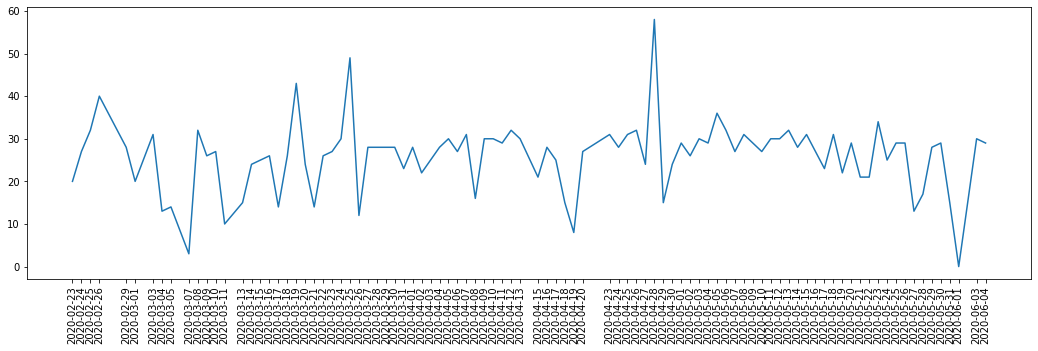

In [367]:
plt.figure(figsize=(18,5))
plt.plot(
    motor_data_avg.index,
    motor_data_avg.time_taken
)
plt.xticks(motor_data_avg.index, rotation=90)

plt.show()

In [ ]:
motor_data_avg['moving_average'] = motor_data_avg.rolling(window=10).mean()

In [ ]:
motor_data_avg['2020-02-23': '2020-03-23'].describe()

In [ ]:
motor_data_avg['2020-03-23': '2020-04-23'].describe()

In [ ]:
motor_data_avg['2020-04-23': '2020-05-23'].describe()

In [ ]:
# My Observations

# 2020-06-07

#1 Average time the motor is turned on is increasing 
#2 Whenever the motor running time is higher then the next day its running time is lower and viceversa

In [342]:
# Average by weekday

In [397]:
motor_data_avg_weekday = motor_data[['day_of_week', 'time_taken']]
motor_data_avg_weekday.loc[:, 'time_taken'] = motor_data_avg_weekday.time_taken.dt.seconds//60
motor_data_avg_weekday = motor_data_avg_weekday.groupby(by=['day_of_week']).mean()

/home/vinaykudari/anaconda3/envs/ml/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [409]:
cats = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']
motor_data_avg_weekday = motor_data_avg_weekday.groupby(['day_of_week']).sum().reindex(cats) 

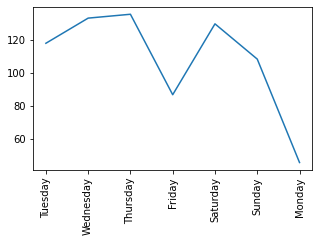

In [412]:
plt.figure(figsize=(5,3))
plt.plot(
    motor_data_avg_weekday.index,
    motor_data_avg_weekday.time_taken
)
plt.xticks(motor_data_avg_weekday.index, rotation=90)

plt.show()

In [413]:
# My Observations

# 2020-06-07

#1 Similar trend observed with respect to steep low and highs

# Questions

#1 Do we have any specific water related activities with respect to weekday? 
#A 